In [98]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import contractions
from sklearn.feature_extraction.text import TfidfVectorizer

In [67]:
# import dataset
data = pd.read_json("yelp_dataset_review_restaurants_sample.json",lines=True)
data.head()

,business_id,cool,date,funny,review_id,stars,text,type,useful,user_id
0,4P-vTvE6cncJyUyLh73pxw,0,2014-03-29,0,6-hKBi-6RC3g7Mft0c-6qw,4,This place is a area staple! Been around for y...,review,0,PmgqNO0-5Y3e3UoR61TD7w
1,4P-vTvE6cncJyUyLh73pxw,0,2014-08-14,0,tRd0-mPa9O1TMJp_dw5khQ,4,Got my mojo back after having a few of their a...,review,0,kXUySHSlRgVrcR4Aa0HtGQ
2,4P-vTvE6cncJyUyLh73pxw,0,2012-10-20,0,8Mu56iQ-MYEyivqUVss0XA,4,"Don't go here for the decor, but the staff is ...",review,1,SYKPwRhnlKrW6yTvm7oPWg
3,4P-vTvE6cncJyUyLh73pxw,1,2012-08-25,0,ToC77cIEiMas9CPU7dt_fA,5,I believe in awarding stars bearing in mind th...,review,2,7LCG3o2KW2jgKgbKN0DQOg
4,4P-vTvE6cncJyUyLh73pxw,0,2015-07-27,0,6YC4o9yLc25DK8c6soOlaw,4,"If you like fried food and laid back, then thi...",review,0,iSdSNh1hjdE33LOwrFnFrg


## Exploratory and Visualization

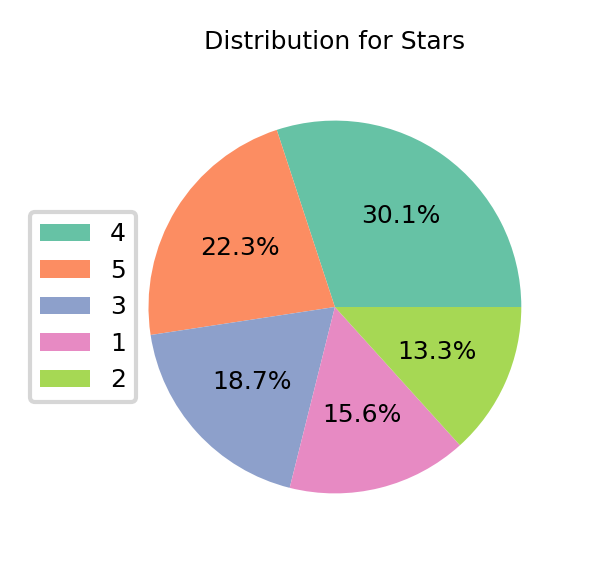

In [68]:
# Distribution of stars for all reviews
sns.set_palette('Set2')

plt.figure(figsize=(3, 2), dpi=300)
stars_num = data["stars"].value_counts()
patches, l_text, p_text = plt.pie(stars_num, autopct='%1.1f%%')
for t in p_text:
    t.set_size(6)
plt.legend(patches, stars_num.index, fontsize=6, title="", loc="center right", bbox_to_anchor=(0, 0, 0.1, 1))
plt.title('Distribution for Stars', fontsize=6)
plt.tight_layout()
plt.show()

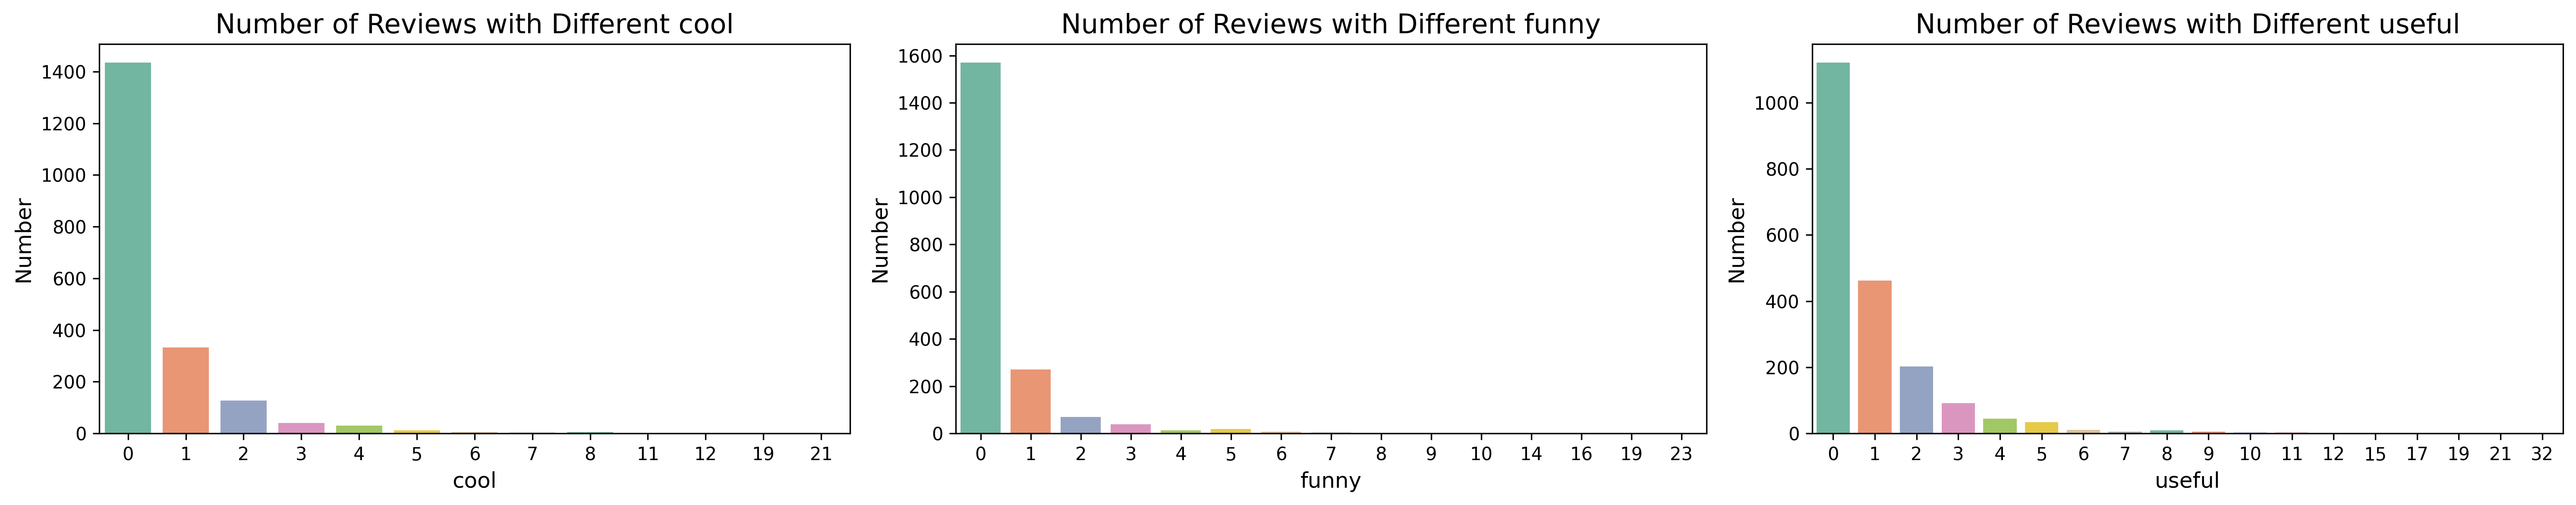

In [69]:
# Distribution of cool, funny, and useful reviews
plt.figure(figsize=(20, 4), dpi=300)
count = 1
for col in ["cool", "funny", "useful"]:
    plt.subplot(1, 3, count)
    sns.countplot(x=col, hue=data[col].astype(str), palette="Set2", legend=False, data=data)
    plt.title('Number of Reviews with Different ' + col, fontsize=15)
    plt.xlabel(col, fontsize=12)
    plt.ylabel("Number", fontsize=12)
    plt.tight_layout()
    count += 1
plt.show()

In [70]:
# extract the information of year, month, day, quarter, and weekday from the feature of date
data["date"] = pd.to_datetime(data["date"])
data["year"] = data["date"].dt.year
data["month"] = data["date"].dt.month
data["day"] = data["date"].dt.day
data["quarter"] = data["date"].dt.quarter
data["weekday"] = data["date"].dt.weekday

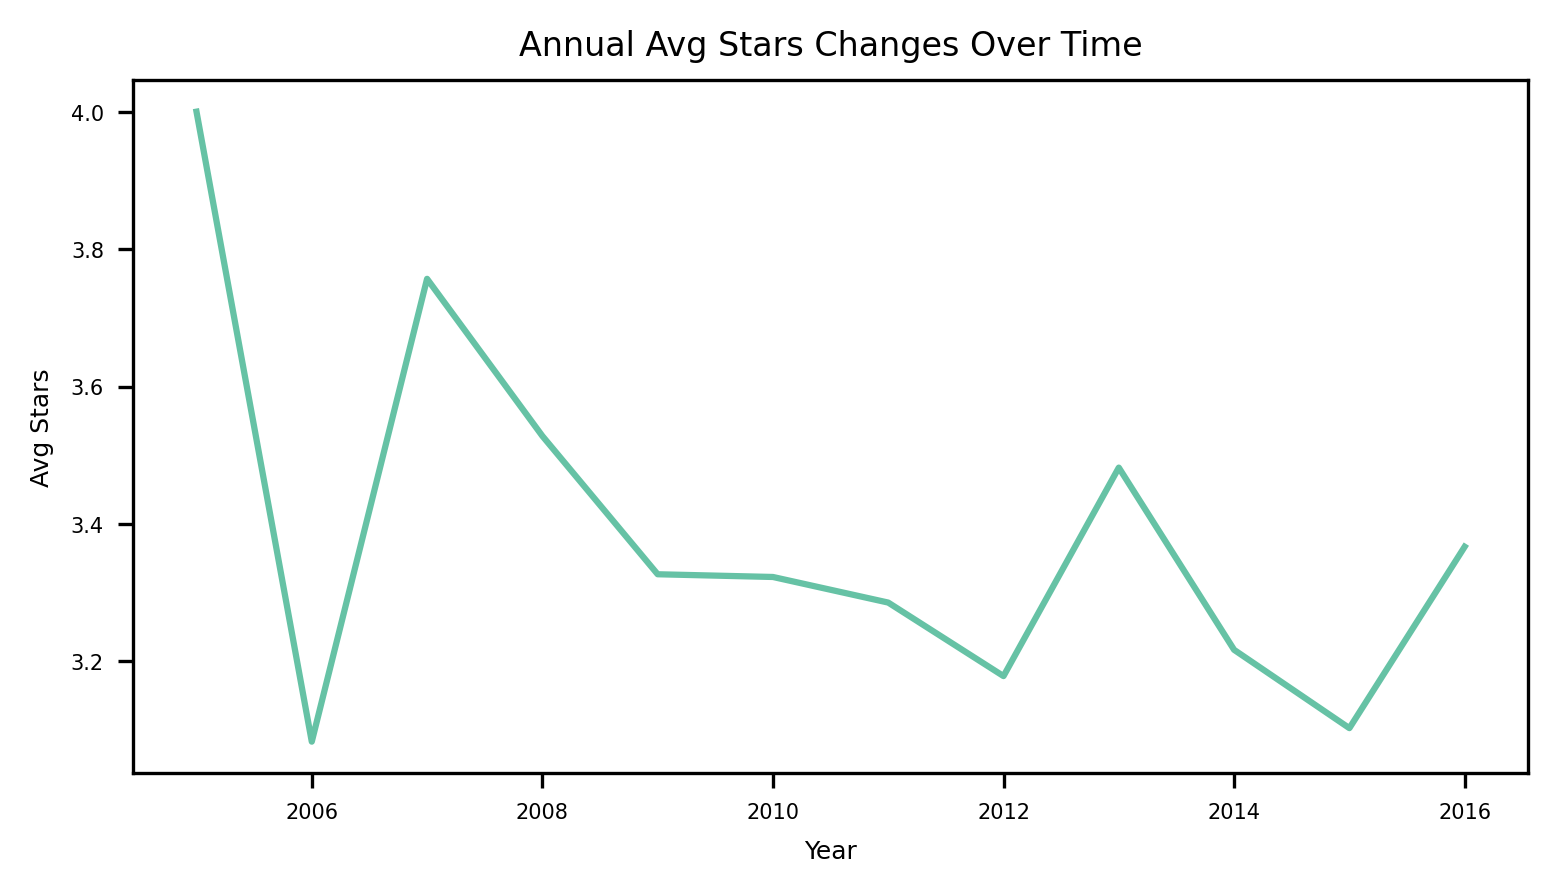

In [71]:
# annual average stars of reviews
plt.figure(figsize=(6, 3), dpi=300)
annual_stars = data.groupby("year")["stars"].mean().reset_index()
sns.lineplot(x="year", y="stars", legend=False, data=annual_stars)
plt.xlabel("Year", fontsize=6)
plt.ylabel("Avg Stars", fontsize=6)
plt.title("Annual Avg Stars Changes Over Time", fontsize=8)
plt.tick_params(labelsize=5)
plt.show()

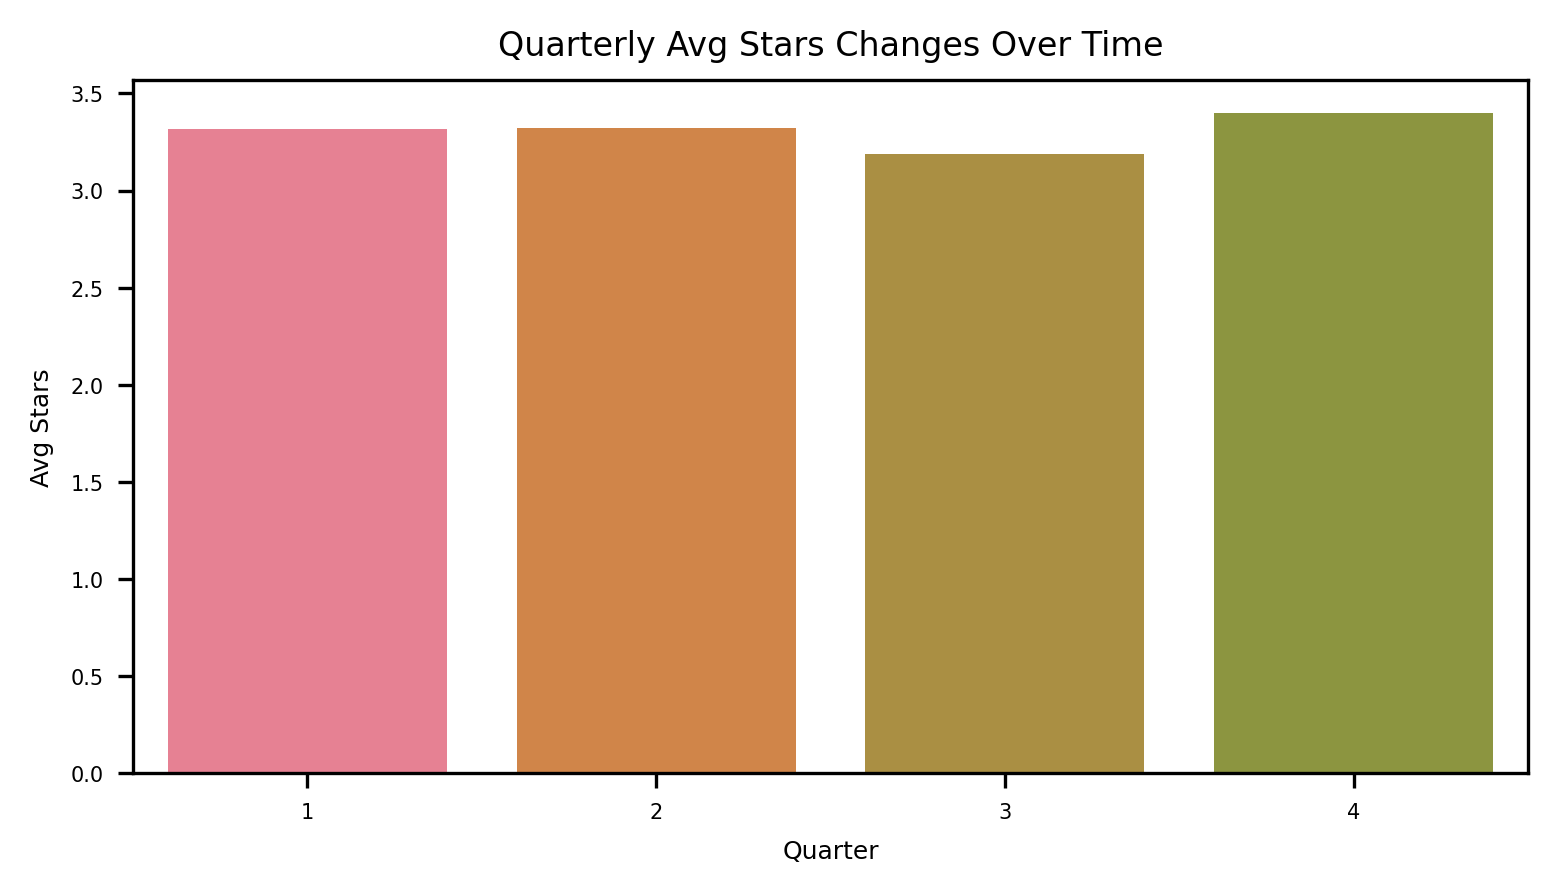

In [73]:
# quarterly average stars of reviews
plt.figure(figsize=(6, 3), dpi=300)
quarterly_stars = data.groupby("quarter")["stars"].mean().reset_index()
sns.barplot(
    x=quarterly_stars["quarter"].astype(str), y="stars", hue=monthly_stars["month"].astype(str), legend=False, data=quarterly_stars
)
plt.xlabel("Quarter", fontsize=6)
plt.ylabel("Avg Stars", fontsize=6)
plt.title("Quarterly Avg Stars Changes Over Time", fontsize=8)
plt.tick_params(labelsize=5)
plt.show()

## Basic Model: Predicting Stars by cool, funny, and useful

In [75]:
# Get X and y and split them into two groups randomly
X = data[["cool", "funny", "useful"]]
y = data["stars"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

In [76]:
# define a function to fit, evalute and visualize model 
def get_performance(model, name, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    conf_mat = confusion_matrix(y_test, preds)
    print("Classification Report for {}:".format(name))
    print(classification_report(y_test, preds))
    
    plt.figure(figsize=(3, 2), dpi=300)
    sns.heatmap(conf_mat, annot=True, fmt="d", cmap="YlGnBu", annot_kws={"fontsize":5}, cbar=False)
    plt.xlabel('Predicted label', fontsize=4)
    plt.ylabel('True label', fontsize=4)
    plt.tick_params(labelsize=4)
    plt.title('Confusion Matrix for {}'.format(name), fontsize=5)
    plt.tight_layout()
    plt.show()

Classification Report for Naive Bayes:
              precision    recall  f1-score   support

           1       0.56      0.09      0.15        56
           2       0.25      0.12      0.16        50
           3       0.33      0.14      0.20        77
           4       0.48      0.12      0.20       122
           5       0.26      0.82      0.39        95

    accuracy                           0.29       400
   macro avg       0.38      0.26      0.22       400
weighted avg       0.38      0.29      0.23       400



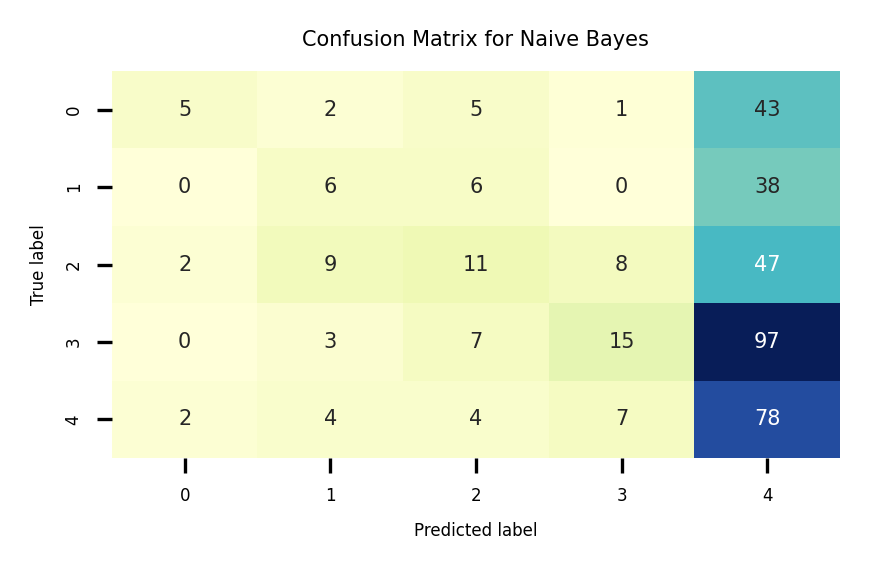

In [77]:
# Get performance of Naive Bayes
get_performance(GaussianNB(), "Naive Bayes", X_train, X_test, y_train, y_test)

Classification Report for KNN:
              precision    recall  f1-score   support

           1       0.18      0.11      0.13        56
           2       0.00      0.00      0.00        50
           3       0.30      0.10      0.15        77
           4       0.30      0.26      0.28       122
           5       0.28      0.65      0.39        95

    accuracy                           0.27       400
   macro avg       0.21      0.23      0.19       400
weighted avg       0.24      0.27      0.23       400



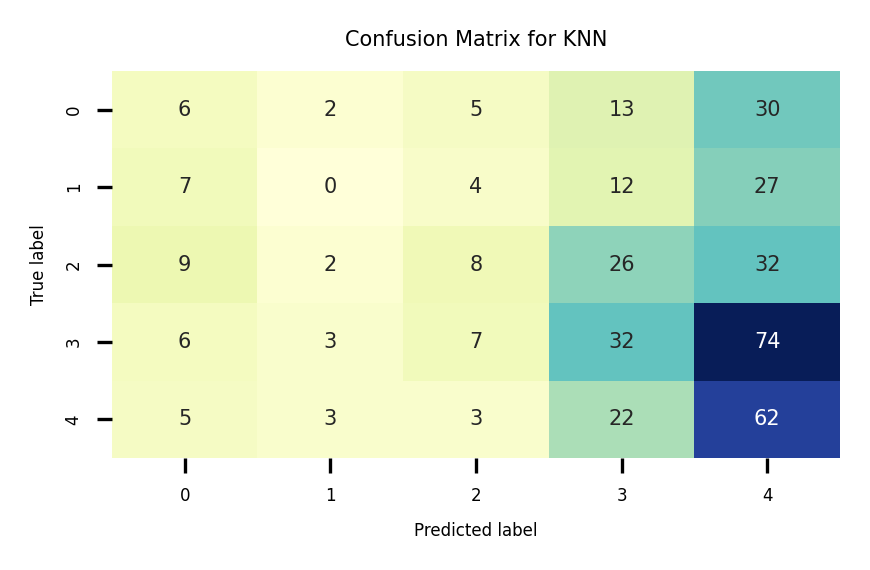

In [78]:
# Get performance of KNN
get_performance(KNeighborsClassifier(), "KNN", X_train, X_test, y_train, y_test)

Classification Report for Random Forest:
              precision    recall  f1-score   support

           1       0.23      0.16      0.19        56
           2       0.00      0.00      0.00        50
           3       0.42      0.10      0.17        77
           4       0.32      0.84      0.46       122
           5       0.22      0.02      0.04        95

    accuracy                           0.30       400
   macro avg       0.24      0.23      0.17       400
weighted avg       0.26      0.30      0.21       400



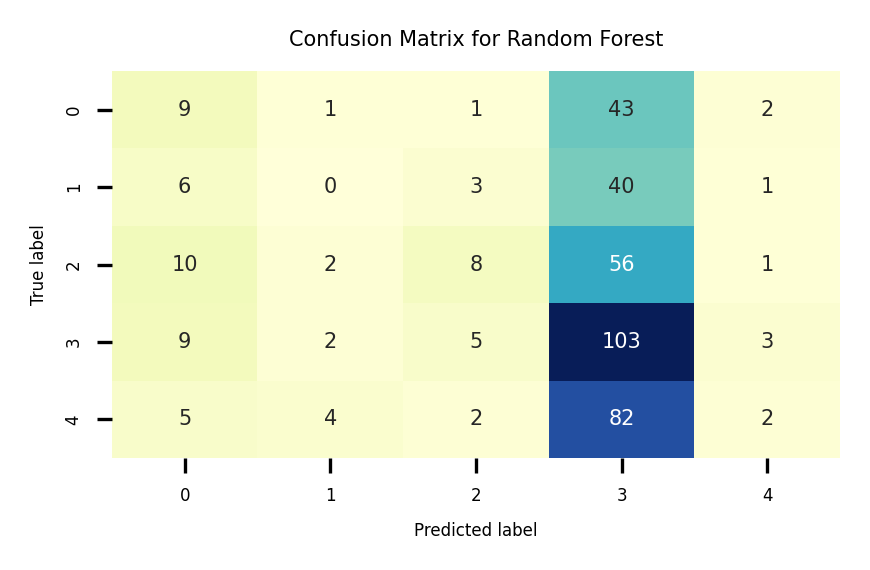

In [79]:
# Get performance of Random forest
get_performance(RandomForestClassifier(random_state=100), "Random Forest", X_train, X_test, y_train, y_test)

## Add text to improve predicting stars

In [92]:
# Define function to clean text
def nltk_pos_to_wordnet_pos(nltk_pos):
    if nltk_pos.startswith('J'):
        return wordnet.ADJ
    elif nltk_pos.startswith('V'):
        return wordnet.VERB
    elif nltk_pos.startswith('N'):
        return wordnet.NOUN
    elif nltk_pos.startswith('R'):
        return wordnet.ADV
    return None

def process_text(text):
    # Contraction Expansion
    expanded_text = contractions.fix(text)
    # Tokenization
    tokens = word_tokenize(expanded_text)
    # Stop-word removal
    tokens = [word for word in tokens if word not in stopword_dict]
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    nltk_pos_tagged = nltk.pos_tag(tokens)
    lemmatized_tokens = []
    for word, nltk_pos in nltk_pos_tagged:
        wordnet_pos = nltk_pos_to_wordnet_pos(nltk_pos)
        if wordnet_pos:
            lemmatized_word = lemmatizer.lemmatize(word, pos=wordnet_pos)
            lemmatized_tokens.append(lemmatized_word)
        else:
            lemmatized_tokens.append(word)
    
    return lemmatized_tokens

In [95]:
# get clean text from original reviews
with open("stopwords.txt", "r") as f:
    stopword_dict = f.read().split("\n")

clean_texts = []
for text in data["text"]:
    clean_text = process_text(text.lower())
    clean_texts.append(clean_text)
data["clean_text"] = clean_texts

In [111]:
# get X and y and split them into two groups randomly
def get_X(texts, max_word_num=10000):
    tfidf_vectorizer = TfidfVectorizer(max_features=max_word_num)
    X_tfidf = tfidf_vectorizer.fit_transform(texts)
    return pd.DataFrame(X_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

X = pd.concat([data[["cool", "funny", "useful"]], get_X(data["clean_text"].apply(lambda x: " ".join(x)))], axis=1)
y = data["stars"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

Classification Report for Naive Bayes:
              precision    recall  f1-score   support

           1       0.40      0.41      0.41        56
           2       0.28      0.28      0.28        50
           3       0.25      0.23      0.24        77
           4       0.38      0.46      0.41       122
           5       0.32      0.24      0.27        95

    accuracy                           0.34       400
   macro avg       0.33      0.33      0.32       400
weighted avg       0.33      0.34      0.33       400



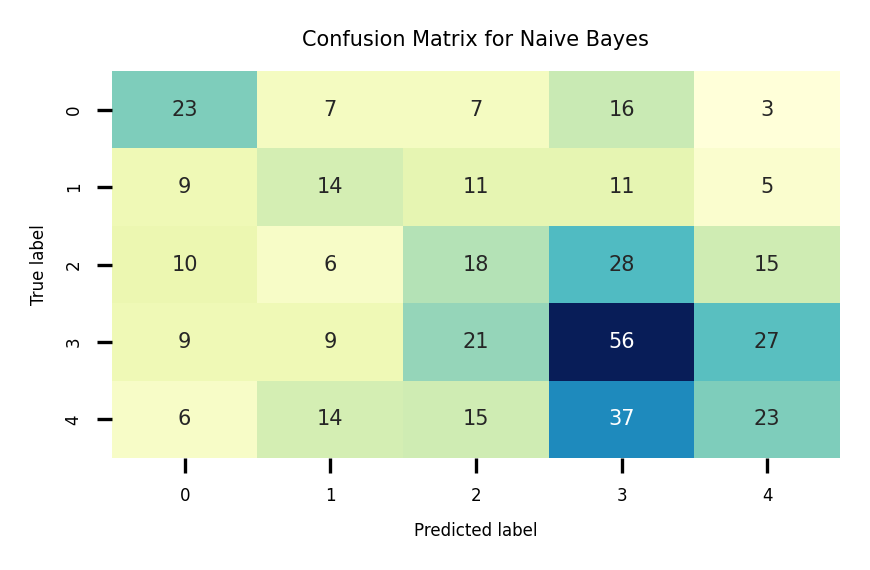

In [112]:
# Get performance of Naive Bayes
get_performance(GaussianNB(), "Naive Bayes", X_train, X_test, y_train, y_test)

Classification Report for KNN:
              precision    recall  f1-score   support

           1       0.37      0.45      0.40        56
           2       0.18      0.24      0.21        50
           3       0.21      0.21      0.21        77
           4       0.33      0.35      0.34       122
           5       0.34      0.21      0.26        95

    accuracy                           0.29       400
   macro avg       0.29      0.29      0.28       400
weighted avg       0.30      0.29      0.29       400



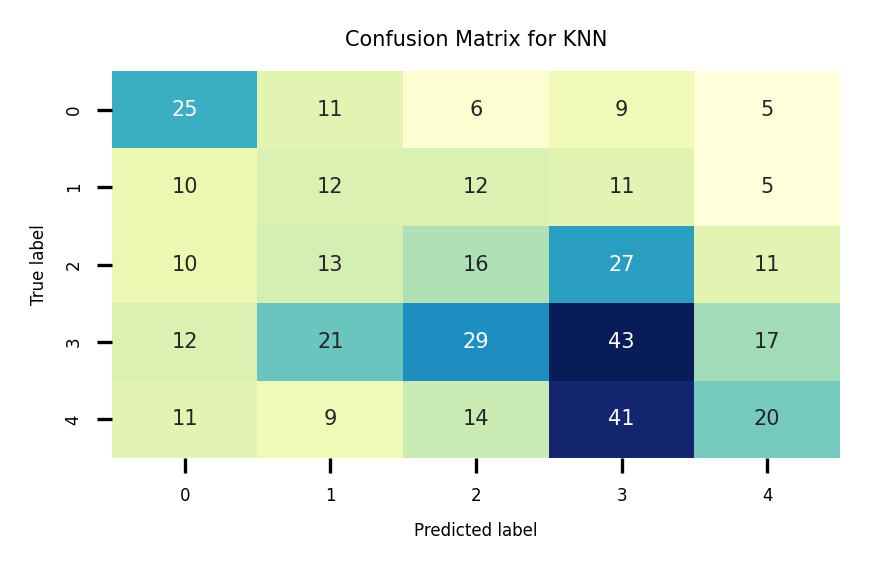

In [113]:
# Get performance of KNN
get_performance(KNeighborsClassifier(), "KNN", X_train, X_test, y_train, y_test)

Classification Report for Random Forest:
              precision    recall  f1-score   support

           1       0.54      0.59      0.56        56
           2       0.33      0.04      0.07        50
           3       0.25      0.14      0.18        77
           4       0.39      0.74      0.51       122
           5       0.57      0.35      0.43        95

    accuracy                           0.42       400
   macro avg       0.42      0.37      0.35       400
weighted avg       0.42      0.42      0.38       400



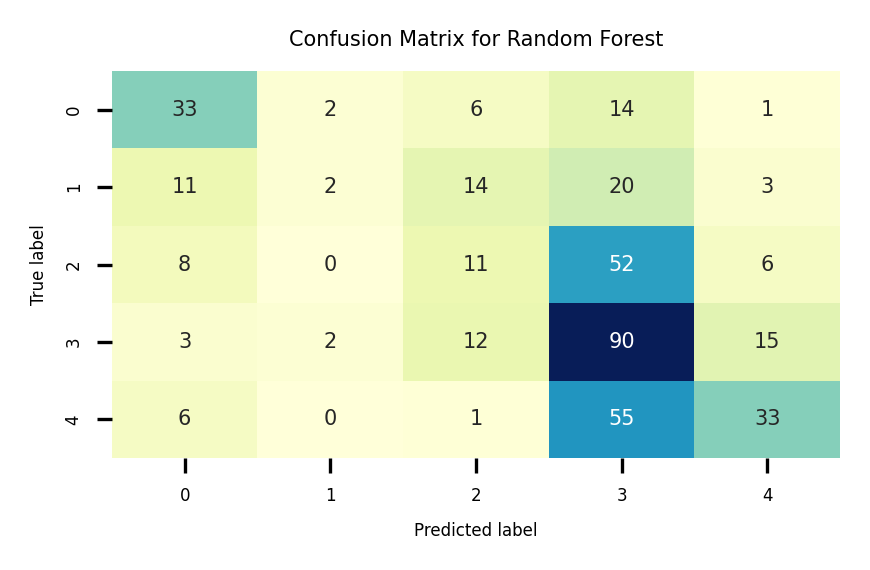

In [114]:
# Get performance of Random Forest
get_performance(RandomForestClassifier(random_state=100), "Random Forest", X_train, X_test, y_train, y_test)